In [1]:
from keras.optimizers import Adam
from keras.utils import to_categorical

import numpy as np
import pandas as pd

import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
import os
from os import listdir
from os.path import isfile, isdir, join
import tensorflow as tf
config =  tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

tf.compat.v1.Session(config = config)
#from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from numpy import genfromtxt
#X = genfromtxt('/content/drive/My Drive/specdata.csv', delimiter=',')
import os.path
mypath2 = "/content/drive/My Drive/note_csv"
files = listdir(mypath2)
files.sort()
c = 0
for f in files:
    if isfile(mypath2 + "/" + f):
        if c == 0:
            y = genfromtxt((mypath2 + "/" + f), delimiter=',')
        else:
            w = genfromtxt((mypath2 + "/" + f), delimiter=',')
            y = np.append(y,w)
            print('\r',c,end='')
        c += 1

#print(X.shape)
print(y.shape)


 99(150000,)


In [4]:
import os.path
mypath2 = "/content/drive/My Drive/cropped_spec_csv"
files = listdir(mypath2)
Xlist = []
c = 0
files.sort()
for f in files:
    if isfile(mypath2 + "/" + f):
        if c == 0:
            w = np.load(mypath2 + "/" + f).astype(np.uint8)
            Xlist = w[:,:,:,:3]
            print(Xlist.shape)

        elif c == 1:
            w = np.load(mypath2 + "/" + f).astype(np.uint8)
            Xlist = np.append(Xlist,w[:,:,:,:3],axis = 0)
        else:
            w = np.load(mypath2 + "/" + f).astype(np.uint8)
            Xlist = np.append(Xlist,w,axis = 0)
            print('\r',c,end='')
        c += 1
Xlist.shape

(1500, 132, 16, 3)
 98

(148500, 132, 16, 3)

In [0]:
from PIL import Image  
#np.int(Xlist[400])
im=Image.fromarray(Xlist[176]) 
im.save( "array_to_image.png")

In [0]:
def build_model(input_shape, num_classes):
#2d cnn
    model = Sequential()
    model.add(
        Conv2D(
            64, 3,
            padding='same',
            activation='relu',
            kernel_regularizer=l2(0.001),
            input_shape=input_shape))
    model.add(
        Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(
        Conv2D(
            128, 3,
            padding='same',
            activation='relu',
            kernel_regularizer=l2(0.001)))
    model.add(Conv2D(128, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))   

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [0]:
def build_model2(input_shape, num_classes):
#2d cnn
    chanDim = -1
    inputs = Input(shape=input_shape)
    x = Conv2D(32,(3, 3), padding="same",kernel_regularizer=l2(0.001))(inputs) 
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)    
    x = Dense(num_classes, activation='softmax')(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model


In [0]:
def build_model(input_shape, nb_classes):
#resnet for 1d?    
    n_feature_maps = 64

    input_layer =  Input(input_shape)

    # BLOCK 1

    conv_x =  Conv1D(filters=n_feature_maps, kernel_size=8, padding='same',kernel_regularizer=l2(0.001))(input_layer)
    conv_x =  BatchNormalization()(conv_x)
    conv_x =  Activation('relu')(conv_x)

    conv_y =  Conv1D(filters=n_feature_maps, kernel_size=5, padding='same',kernel_regularizer=l2(0.001))(conv_x)
    conv_y =  BatchNormalization()(conv_y)
    conv_y =  Activation('relu')(conv_y)

    conv_z =  Conv1D(filters=n_feature_maps, kernel_size=3, padding='same',kernel_regularizer=l2(0.001))(conv_y)
    conv_z =  BatchNormalization()(conv_z)
    conv_z =  MaxPooling1D(pool_size=2)(conv_z)
    conv_z =  Dropout(0.25)(conv_z)

    # expand channels for the sum
    shortcut_y =  Conv1D(filters=n_feature_maps, kernel_size=1, padding='same',kernel_regularizer=l2(0.001))(input_layer)
    shortcut_y =  BatchNormalization()(shortcut_y)
    shortcut_y =  MaxPooling1D(pool_size=2)(shortcut_y)
    shortcut_y =  Dropout(0.25)(shortcut_y)

    output_block_1 =  add([shortcut_y, conv_z])
    output_block_1 =  Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x =  Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same',kernel_regularizer=l2(0.001))(output_block_1)
    conv_x =  BatchNormalization()(conv_x)
    conv_x =  Activation('relu')(conv_x)

    conv_y =  Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same',kernel_regularizer=l2(0.001))(conv_x)
    conv_y =  BatchNormalization()(conv_y)
    conv_y =  Activation('relu')(conv_y)

    conv_z =  Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same',kernel_regularizer=l2(0.001))(conv_y)
    conv_z =  BatchNormalization()(conv_z)
    conv_z =  MaxPooling1D(pool_size=2)(conv_z)
    conv_z =  Dropout(0.25)(conv_z)

    # expand channels for the sum
    shortcut_y =  Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same',kernel_regularizer=l2(0.001))(output_block_1)
    shortcut_y =  BatchNormalization()(shortcut_y)
    shortcut_y =  MaxPooling1D(pool_size=2)(shortcut_y)
    shortcut_y =  Dropout(0.25)(shortcut_y)

    output_block_2 =  add([shortcut_y, conv_z])
    output_block_2 =  Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x =  Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same',kernel_regularizer=l2(0.001))(output_block_2)
    conv_x =  BatchNormalization()(conv_x)
    conv_x =  Activation('relu')(conv_x)

    conv_y =  Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same',kernel_regularizer=l2(0.001))(conv_x)
    conv_y =  BatchNormalization()(conv_y)
    conv_y =  Activation('relu')(conv_y)

    conv_z =  Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same',kernel_regularizer=l2(0.001))(conv_y)
    conv_z =  BatchNormalization()(conv_z)
    conv_z =  MaxPooling1D(pool_size=2)(conv_z)
    conv_z =  Dropout(0.25)(conv_z)

    # no need to expand channels because they are equal
    shortcut_y =  BatchNormalization()(output_block_2)
    shortcut_y =  MaxPooling1D(pool_size=2)(shortcut_y)
    shortcut_y =  Dropout(0.25)(shortcut_y)
    output_block_3 =  add([shortcut_y, conv_z])
    output_block_3 =  Activation('relu')(output_block_3)

    # FINAL

    gap_layer =  GlobalAveragePooling1D()(output_block_3)

    output_layer =  Dense(nb_classes, activation='softmax')(gap_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    opt = tf.keras.optimizers.Adam(lr=1e-4, decay=1e-4 / 100)

    model.compile(loss='categorical_crossentropy', optimizer=opt,
                  metrics=['accuracy'])

    return model

In [0]:
def build_set_branch(inputs, finalAct="softmax", chanDim=-1,n = ""):
		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(inputs)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(3, 3))(x)
		x = Dropout(0.25)(x)
    # (CONV => RELU) * 2 => POOL
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)
		x = Flatten()(x)
		x = Dense(256)(x)
		x = Activation("relu")(x)
		x = BatchNormalization()(x)
		x = Dropout(0.5)(x)
		x = Dense(1, activation="linear",name=n)(x)
		# return the category prediction sub-network
		return x
def build_pitch_branch(inputs, numCategories, finalAct="softmax", chanDim=-1):
		# CONV => RELU => POOL
		x = Conv2D(32, (3, 3), padding="same")(inputs)
		x = ELU(alpha=0.1)(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(3, 3))(x)
		x = Dropout(0.25)(x)
    # (CONV => RELU) * 2 => POOL
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = ELU(alpha=0.1)(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = Conv2D(64, (3, 3), padding="same")(x)
		x = ELU(alpha=0.1)(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
		x = Dropout(0.25)(x)
		x = Flatten()(x)
		x = Dense(256)(x)
		x = ELU(alpha=0.1)(x)
		x = BatchNormalization()(x)
		x = Dropout(0.5)(x)
		x = Dense(numCategories)(x)
		x = Activation(finalAct, name="category_output")(x)
		# return the category prediction sub-network
		return x
def build(height,width , numCategories, finalAct="softmax"):
    # initialize the input shape and channel dimension (this code
    # assumes you are using TensorFlow which utilizes channels
    # last ordering)
    inputShape = (height, width, 3)
    chanDim = -1
    # construct both the "category" and "color" sub-networks
    inputs = Input(shape=inputShape)
    pitchBranch = build_pitch_branch(inputs, numCategories, finalAct=finalAct, chanDim=chanDim)
    #onsetBranch = build_set_branch(inputs, finalAct=finalAct, chanDim=chanDim,n = "onset_output")
    #offsetBranch = build_set_branch(inputs, finalAct=finalAct, chanDim=chanDim,n = "offset_output")
    # create the model using our input (the batch of images) and
    # two separate outputs -- one for the clothing category
    # branch and another for the color branch, respectively
    model = Model(inputs=inputs, outputs=pitchBranch )
    # return the constructed network architecture
    return model

In [0]:
def rename(num):
    num = int(num)
    if num < 10:
        return "000"+str(num)
    elif num < 100 and num >= 10:
        return "00"+str(num)
    elif num < 1000 and num >= 100:
        return "0"+str(num)
    else:
        return str(num)

In [0]:
import os.path
mypath2 = "/content/drive/My Drive/cropped_spec"
files = listdir(mypath2)
filenamelist = []
c = 0
files.sort()
for f in files:
    pc = 0
    files2 = listdir(mypath2 + "/" + f)
    files2.sort()
    for f2 in files2:
        filenamelist.append(mypath2 + "/" + f + "/" +f2)
        pc += 1
    #print(str(c) + ", "+str(pc))
    c += 1

In [0]:
import cv2
import os
from keras.preprocessing.image import img_to_array
def Imageproc(flist):
    data = []
    i = 0
    for f in flist:
        image = cv2.imread(f)
        image = img_to_array(image)
        data.append(image)
        #print('\r',i,end='')
        i += 1
    data = np.array(data, dtype="float")
    return data

def imageLoader(files, batch_size,start,end):

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = start
        batch_end = batch_size

        while batch_start < end:
            limit = min(batch_end, end)
            X = Imageproc(files[batch_start:limit])
     #       Y = {"onset_output":y[batch_start:limit,0],"offset_output": y[batch_start:limit,1],
     #            "category_output": pitch_train[batch_start:limit]}
            Y = pitch_train[batch_start:limit]

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [0]:
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.models import Model, Sequential
from keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Concatenate, Input, Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Activation, Flatten, ELU

EPOCHS = 50
INIT_LR = 1e-3
batch_size = 50
print(Xlist.shape)
#split = train_test_split(X, y[:,0], y[:,1], y[:,2], test_size=0.2, random_state=42)
#(trainX, testX, trainOnsetY, testOnsetY, trainOffsetY, testOffsetY, trainPitchY, testPitchY) = split

trainX, testX, trainPitchY, testPitchY = train_test_split(Xlist, y[:148500], test_size=0.2, random_state=42)

ReX_train = trainX.reshape(-1, 132*16*3)
rus = RandomOverSampler(random_state=42,sampling_strategy='not majority')
X_pre, y = rus.fit_resample(ReX_train, trainPitchY)
X = X_pre.reshape(-1,132,16,3)

pitch_train = to_categorical(y[:148500])
pitch_test = to_categorical(testPitchY)
print(pitch_train.shape)
#model = build(16, 97, numCategories=pitch_train.shape[1], finalAct="softmax")
model = build_model((132,16,3), pitch_train.shape[1])
# define two dictionaries: one that specifies the loss method for
# each output of the network along with a second dictionary that
# specifies the weight per loss
'''
losses = {
	"onset_output": "mean_absolute_percentage_error",
  "offset_output": "mean_absolute_percentage_error",
	"category_output": "categorical_crossentropy",
}
lossWeights = {"onset_output": 1.0, "offset_output": 1.0, "category_output": 1.0}
'''
# initialize the optimizer and compile the model
print("[INFO] compiling model...")


opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
#	metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=opt,
                  metrics=['accuracy'])


history = model.fit(Xlist,pitch_train,batch_size=batch_size,validation_data=(testX,pitch_test),epochs=EPOCHS,verbose=1)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()	

(148500, 132, 16, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(148500, 78)
[INFO] compiling model...
Epoch 1/50
2967/2970 [============================>.] - ETA: 0s - loss: 3.4971 - accuracy: 0.0487

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Concatenate, Input, Conv2D, MaxPooling2D,Dense, Dropout, Activation, Flatten

x_train = x_train_pre.reshape((x_train_pre.shape[0], 8,8,1))
X_test= X_test.reshape((X_test.shape[0], 8,8,1))
x_train = X.reshape((X.shape[0], 8,8,1))
# 影像大小
IMAGE_SIZE = (8, 8)

# 影像類別數
NUM_CLASSES = 22

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 90

# 凍結網路層數
FREEZE_LAYERS = 20

# Epoch 數
NUM_EPOCHS = 50

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-resnet50-final.h5'

img_input = Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1))
img_conc = Concatenate()([img_input, img_input, img_input]) 

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=img_conc)
x = net.output
x = Flatten()(x)
# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=img_input , outputs=output_layer)

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 訓練模型
history = net_final.fit_generator(balanced_gen,
                        steps_per_epoch=steps_per_epoch,                        
                        epochs = NUM_EPOCHS,workers=1,use_multiprocessing=False)
#validation_data = valid_batches,
#validation_steps = int(valid_batches.x.shape[0]/BATCH_SIZE),

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/50
4877/4877 [==============================] - 109s 22ms/step - loss: 1.7749 - accuracy: 0.7308 - val_loss: 1.7273 - val_accuracy: 0.6855
Epoch 2/50
4877/4877 [==============================] - 111s 23ms/step - loss: 1.2738 - accuracy: 0.7832 - val_loss: 1.4839 - val_accuracy: 0.7023
Epoch 3/50
4877/4877 [==============================] - 112s 23ms/step - loss: 1.0913 - accuracy: 0.7938 - val_loss: 1.3127 - val_accuracy: 0.7166
Epoch 4/50
4877/4877 [==============================] - 111s 23ms/step - loss: 0.9805 - accuracy: 0.8001 - val_loss: 1.2414 - val_accuracy: 0.7185
Epoch 5/50
4877/4877 [==============================] - 112s 23ms/step - loss: 0.9061 - accuracy: 0.8048 - val_loss: 1.1683 - val_accuracy: 0.7234
Epoch 6/50
4877/4877 [==============================] - 111s 23ms/step - loss: 0.8542 - accuracy: 0.8087 - val_loss: 1.2007 - val_accuracy: 0.7016
Epoch 7/50
4877/4877 [==============================] - 111s 23ms/step - loss: 0.8167 - accuracy: 0.8120 - val_loss: 1

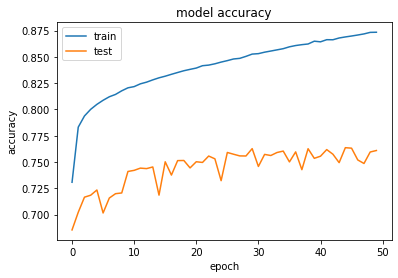

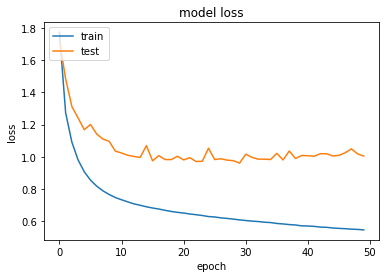

In [0]:
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout,add,GlobalAveragePooling1D,Dense,Activation

num_epochs = 50
num_batch_size = 32

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = build_model((64,1),77)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
history = model.fit(x_train, y_train_cat, batch_size=num_batch_size, epochs=num_epochs, verbose=1,validation_data = (X_test,y_test_cat))
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
score = model.evaluate(Xlist,pitch_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
#score = model.evaluate(X_test, y_test_cat, verbose=0)
#print("Testing Accuracy: {0:.2%}".format(score[1]))
model_json = model.to_json()
with open("/content/drive/My Drive/Colab Notebooks/model_vocal.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Colab Notebooks/model_vocal.h5")
print("Saved model to disk")

Training Accuracy: 54.20%
Saved model to disk


[[155   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   7 ...   0   0   0]
 ...
 [  0   0   0 ...  30   0   0]
 [  0   0   0 ...   0   3   0]
 [  0   0   0 ...   0   0   1]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


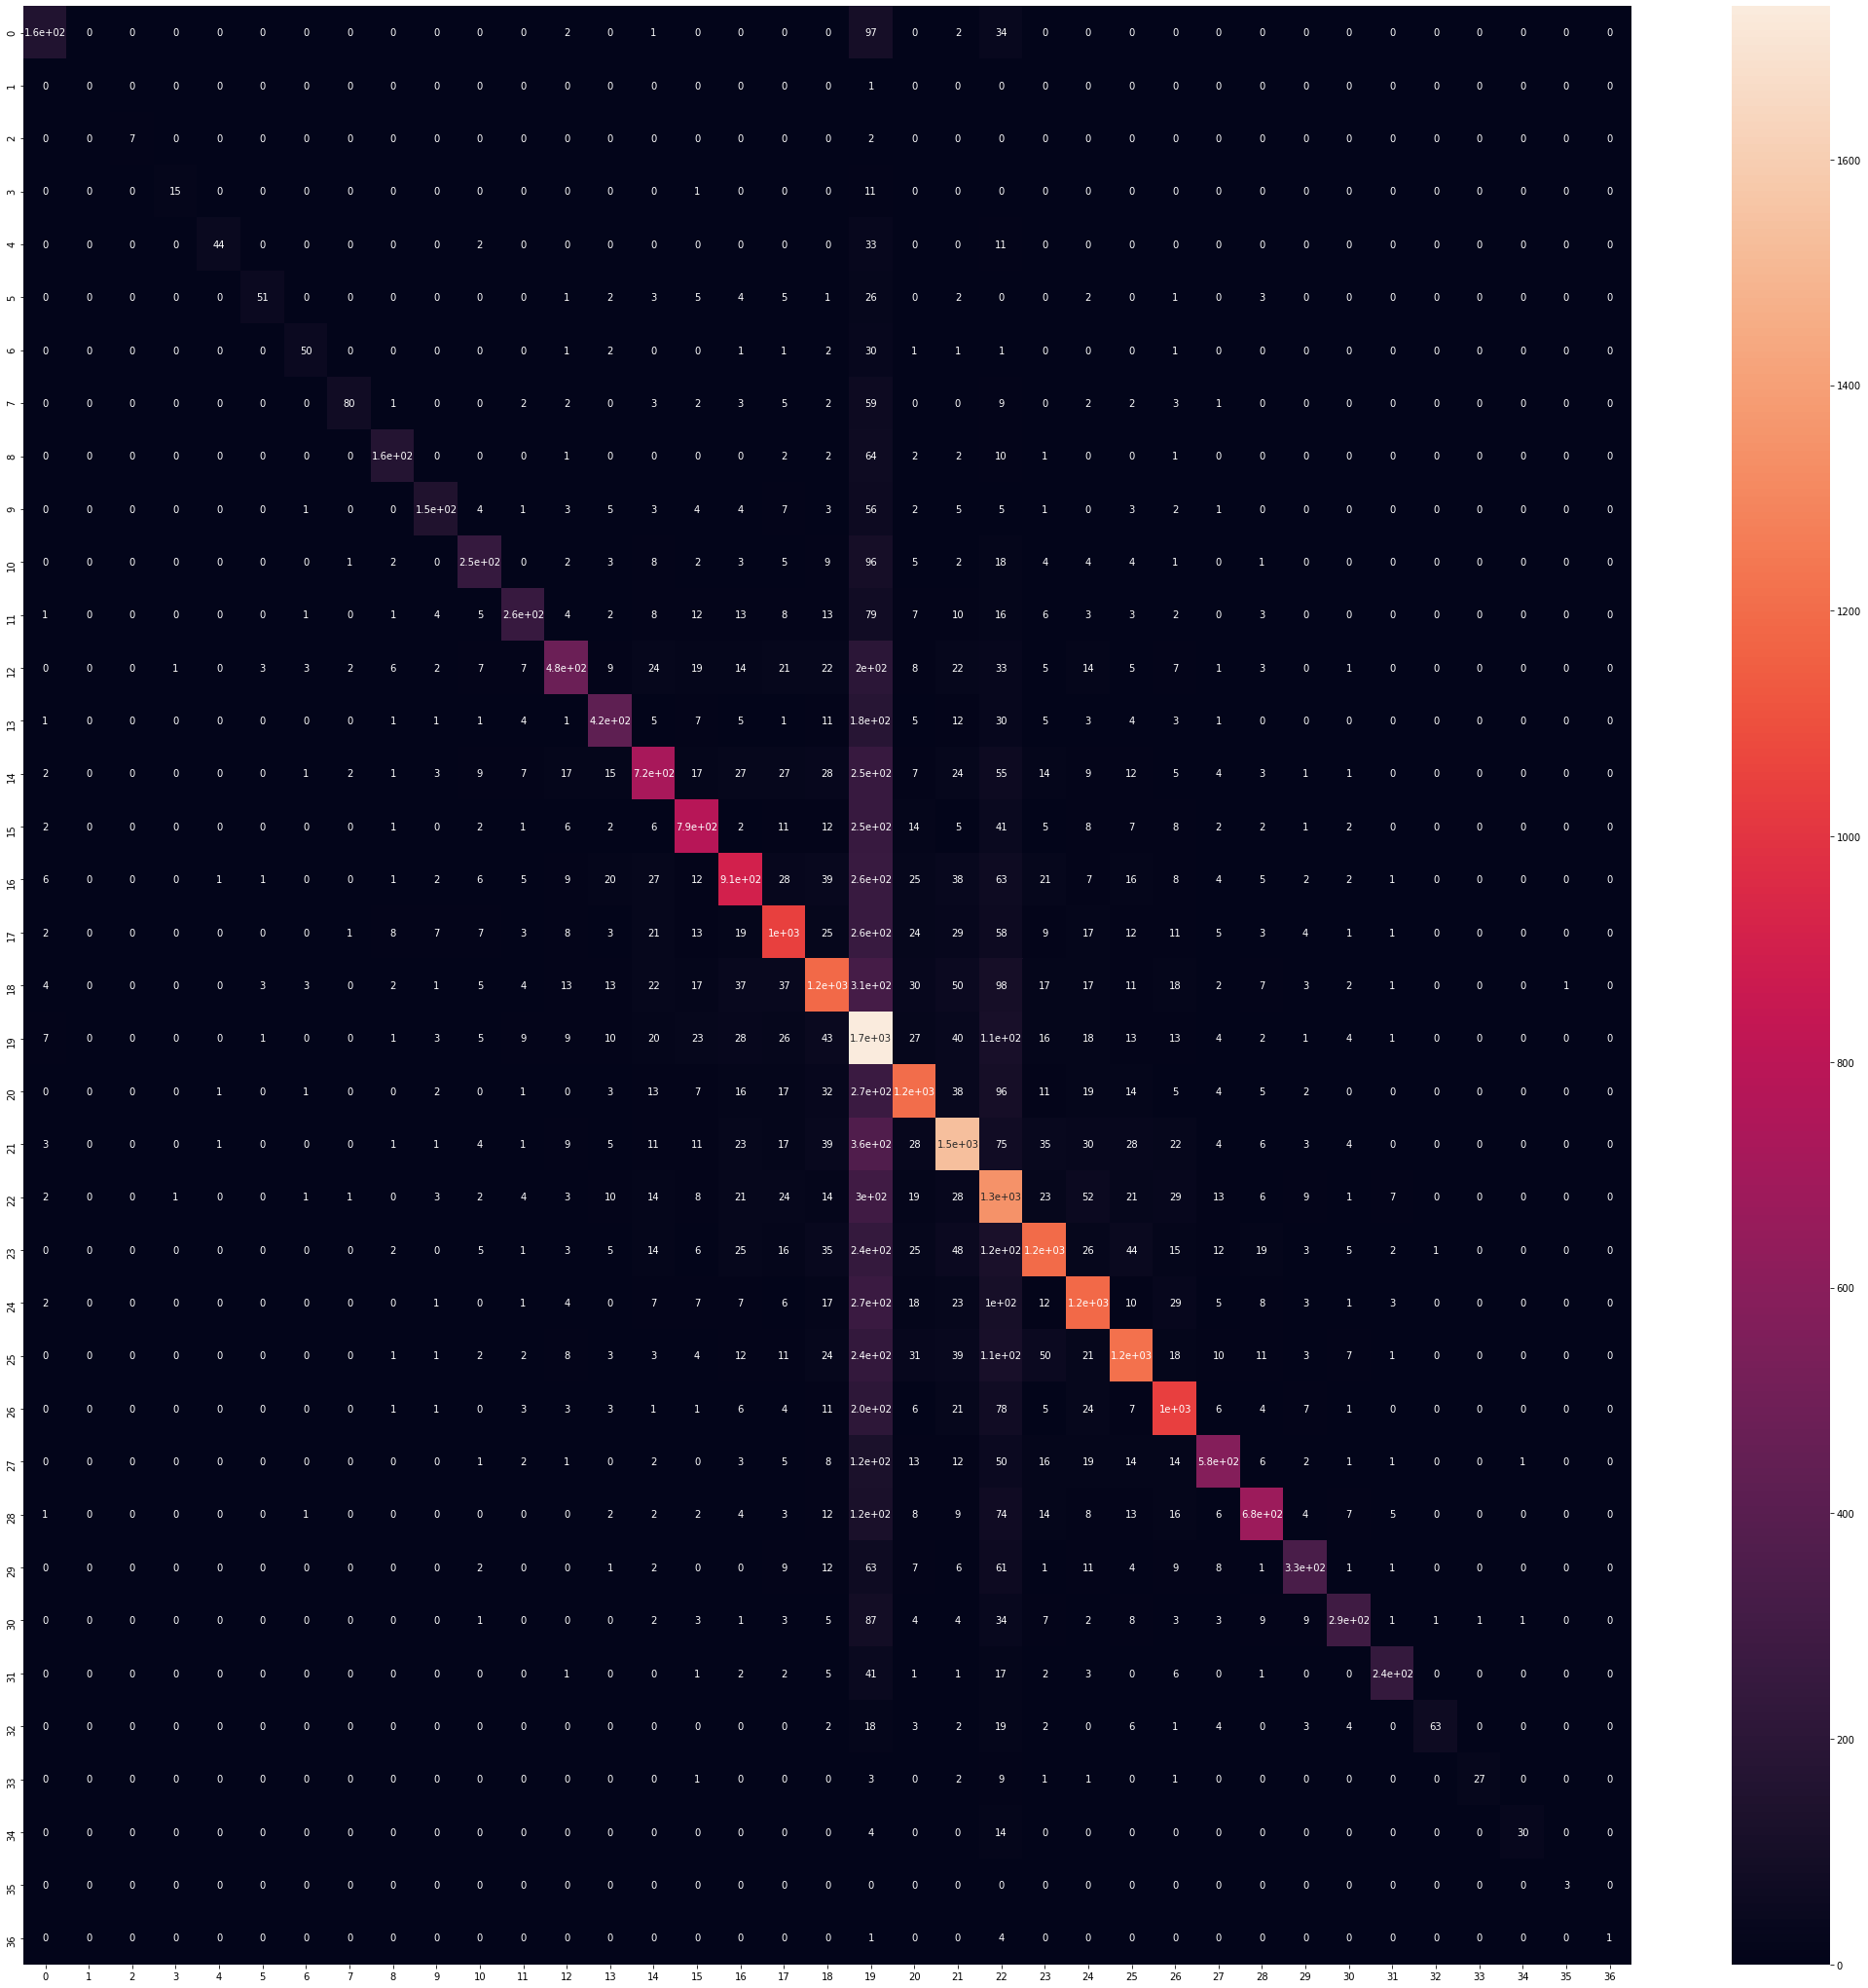

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
trainX, testX, trainPitchY, testPitchY = train_test_split(Xlist, y[:148500], test_size=0.2, random_state=42)
y_pred = model.predict(testX)

cm=confusion_matrix(np.argmax(to_categorical(testPitchY), axis=1),np.argmax(y_pred, axis=1))
print(cm)

import seaborn as sn
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (cm.shape[0],cm.shape[1]))
sn.heatmap(df_cm, annot=True)

In [0]:
#p = extract_features("C:/Users/andy/test\\whitelotus_vocal2.wav").reshape(1,40)
#audio, sr = librosa.load(filename[0], res_type='kaiser_fast') 
audio, sr = librosa.load(filename[0], sr =16000, res_type='kaiser_fast',mono = False) 
buffer = sr*0.032
result = []
samples_wrote = sr*0.016
counter = 1
estimates = test.separate(audio=audio.T, targets=['vocals'], residual_model=False,niter=1,device = device)
novoc = estimates.get('vocals').T.sum(axis=0) / 2
samples_total = len(novoc)
while samples_wrote < samples_total:
        #check if the buffer is not exceeding total samples 
    if buffer > (samples_total - samples_wrote):
        buffer = samples_total - samples_wrote

    block = novoc[round(samples_wrote) : round(samples_wrote + buffer)]
    #if block.size < 706:
        #break
    mfccs = librosa.feature.mfcc(y=block, sr=sr, n_mfcc=64)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    #p = mfccs_processed.reshape(1,64)
    ##stft = np.abs(librosa.stft(block,n_fft=64))
    
   
    result.append(mfccs_processed)
    counter += 1
    samples_wrote += buffer

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


In [0]:
print(np.array(result).shape)
p = np.array(result).reshape(8326,8,8,1)
a =  net_final.predict(p)
#a = model.predict(p.reshape(128,))
#a1 = np.squeeze(a,axis = 0)
#a2 = np.array(result)
a3 = np.argmax(a,axis = 1)
#a4 = le.inverse_transform(a3.astype(int))
np.savetxt('/content/drive/My Drive/Colab Notebooks/data2.csv', a3, delimiter=',')

(8326, 64)
